# *Chapter - 3*

In [1]:
## PART - 2 - Image based RAG

In [ ]:
%%capture
!pip install torch torchvision sentence-transformers chromadb

# COCO Image embeddings

In [1]:
from dotenv import load_dotenv
import os
from PIL import Image
import torch
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel
import random
import json
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from langchain.schema import Document
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

# Load environment variables
load_dotenv('.env')

# Load the CLIP model
model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_name)
clip_processor = CLIPProcessor.from_pretrained(model_name)

def get_image_embedding(image_path):
    """Embed an image using CLIP."""
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    inputs = clip_processor(images=image, return_tensors="pt", padding=True)

    # Generate embeddings
    with torch.no_grad():
        embedding = clip_model.get_image_features(**inputs)
    return embedding.squeeze().numpy()  # Convert to numpy array

C:\Users\charu\anaconda3\envs\RAG\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialize ChromaDB
vectordb = Chroma(
    persist_directory="./coco_image_chromaDB",  # Directory for storing the vector database
    embedding_function=OpenAIEmbeddings()  # Embedding function
)

# Load COCO dataset
coco_annotations_file = './coco_dataset/annotations/image_info_test.json'  # path to COCO captions file
coco_image_dir = './coco_dataset/images/'  # path to COCO images

# Initialize COCO API
coco = COCO(coco_annotations_file)

# Get all image ids
image_ids = coco.getImgIds()

# Randomly select 30% of images
selected_image_ids = random.sample(image_ids, int(0.3 * len(image_ids)))

C:\Users\charu\AppData\Local\Temp\ipykernel_2900\4066889098.py:2: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectordb = Chroma(


loading annotations into memory...
Done (t=0.12s)
creating index...
index created!


In [5]:
selected_image_ids

[456706,
 95126,
 144989,
 42623,
 373681,
 461441,
 504281,
 271739,
 36398,
 337696,
 19561,
 3024,
 186292,
 544083,
 34809,
 215801,
 93903,
 6670,
 499481,
 109347,
 502706,
 577915,
 130257,
 480856,
 49571,
 146880,
 113482,
 203983,
 383654,
 417462,
 279836,
 423979,
 267602,
 235633,
 265376,
 425095,
 537418,
 336893,
 43456,
 354812,
 358110,
 51169,
 278103,
 3367,
 327003,
 430179,
 406960,
 358026,
 150496,
 311625,
 99384,
 81045,
 145084,
 162472,
 282079,
 83590,
 374908,
 5127,
 253370,
 350237,
 100210,
 137791,
 206103,
 11399,
 258692,
 217313,
 21016,
 110719,
 34945,
 9689,
 116038,
 214656,
 93987,
 213454,
 292717,
 489536,
 2949,
 514328,
 539724,
 33453,
 152241,
 545617,
 251898,
 263001,
 78653,
 119824,
 319029,
 452273,
 80534,
 305561,
 538935,
 19229,
 1657,
 231661,
 291859,
 528942,
 17314,
 184180,
 392333,
 496848,
 335461,
 180904,
 21239,
 105203,
 4311,
 367965,
 114384,
 353842,
 90022,
 363685,
 286599,
 362330,
 265775,
 388333,
 375459,
 910

In [3]:
# Prepare a list of documents to add to the vector store
documents = []

for image_id in selected_image_ids:
    # Get image info
    image_info = coco.loadImgs(image_id)[0]
    image_file = image_info['file_name']
    image_path = os.path.join(coco_image_dir, image_file)
    
    # Get the image embedding (assuming 'get_image_embedding' is defined)
    image_embedding = get_image_embedding(image_path)  # Get image embedding
    
    # Convert the embedding to a JSON-compatible string
    embedding_str = json.dumps(image_embedding.tolist())  # Convert to list and then string
    
    # Create the Document with embedding stored in metadata
    doc = Document(
        page_content="",  # Empty since we don't have text content
        metadata={
            "source": image_file,  # File name as metadata
            "embedding": embedding_str,  # Store embedding as string
        }
    )
    
    # Add the document to the list
    documents.append(doc)

# Add documents to the vector store
vectordb.add_documents(documents)

# Persist updated vector store
vectordb.persist()

C:\Users\charu\AppData\Local\Temp\ipykernel_2900\3488133719.py:32: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectordb.persist()


C:\Users\charu\AppData\Local\Temp\ipykernel_2900\1588205520.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], cmap='viridis', s=50)


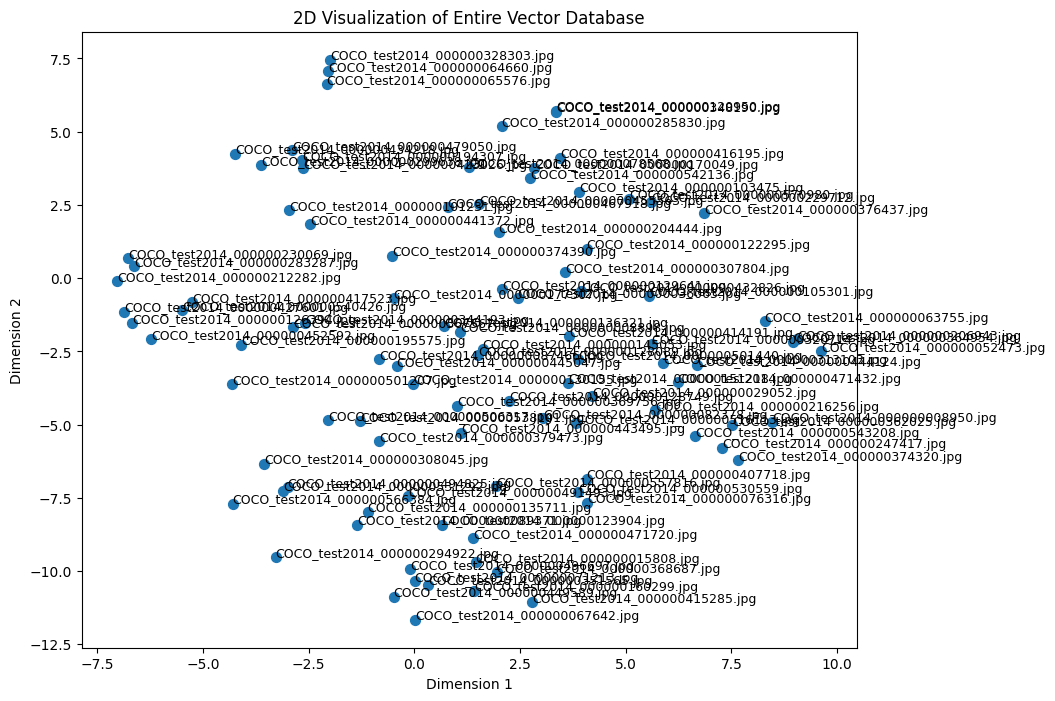

In [21]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Retrieve all documents from the vector store
all_documents = vectordb.similarity_search(" ", k=100)  # Use a high value for `k` to get all documents

# Retrieve embeddings and corresponding image sources
embeddings = []
image_sources = []

for doc in all_documents:
    image_sources.append(doc.metadata["source"])
    embedding = json.loads(doc.metadata["embedding"])  # Convert back to list
    embeddings.append(embedding)

# Convert list of embeddings into a numpy array
embeddings = np.array(embeddings)

# Perform dimensionality reduction using t-SNE
n_samples = embeddings.shape[0]
perplexity = min(n_samples - 1, 30)  # Ensure perplexity is valid for the dataset size
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings)

# Plot the embeddings
plt.figure(figsize=(10, 8))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], cmap='viridis', s=50)

# Annotate each point with the corresponding image source
for i, source in enumerate(image_sources):
    plt.annotate(source, (tsne_embeddings[i, 0], tsne_embeddings[i, 1]), fontsize=9)

plt.title('2D Visualization of Entire Vector Database')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


### Generate Captions for COCO images

In [25]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# Initialize BLIP model and processor for image captioning
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Initialize CLIP or Sentence Transformer for image and text embeddings
clip_model = SentenceTransformer("clip-ViT-B-32")  # CLIP model from Sentence Transformers

# Folder containing COCO images
image_folder = './coco_dataset/images/'

# Function to generate captions using BLIP
def generate_caption(image_path):
    raw_image = Image.open(image_path).convert("RGB")
    inputs = processor(raw_image, return_tensors="pt")
    out = model.generate(**inputs)
    caption = processor.decode(out[0], skip_special_tokens=True)
    return caption

# Load 30% of images from the COCO dataset
image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
num_images = int(0.3 * len(image_paths))  # Select 30% of images
selected_image_paths = image_paths[:num_images]

In [28]:
# Limit to 200 images
selected_image_paths = selected_image_paths[:200]

# Generate captions for the first 100 images
captions = []

for image_path in selected_image_paths:
    caption = generate_caption(image_path)
    captions.append(caption)

# Embed images using CLIP
def get_image_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    image_embedding = clip_model.encode([image])  # Produces a 2D array
    return image_embedding

image_embeddings = np.array([get_image_embedding(image_path) for image_path in selected_image_paths])


In [29]:
captions

['a truck is parked in front of a fence',
 'a man standing on the side of a road',
 'a baseball player swinging at a ball during a game',
 'a dog in a car',
 'a man playing tennis',
 'a man and a woman playing baseball in a field',
 'a woman wearing a black and white striped shirt',
 'a zebra standing next to a fence',
 'a dog laying on the floor',
 'a cow grazing in a field',
 'a bird on a bird bath',
 'a train on the tracks',
 'a elephant standing on a box',
 'a brown teddy bear',
 'a man in a suit and tie holding his head',
 'a man playing tennis on a tennis court',
 'a motorcycle parked on the side of a road',
 'a black bear walking through a forest',
 'an old truck in a field',
 'a man in a suit and tie with a green apple on his head',
 'a remote control sitting on a couch',
 'the plane is in the air',
 'man wearing a suit',
 'a boy jumping on a skateboard',
 'a man is playing tennis on a tennis court',
 'a gifet standing next to a tree',
 'a woman in a bikini',
 'a surfer is ridi

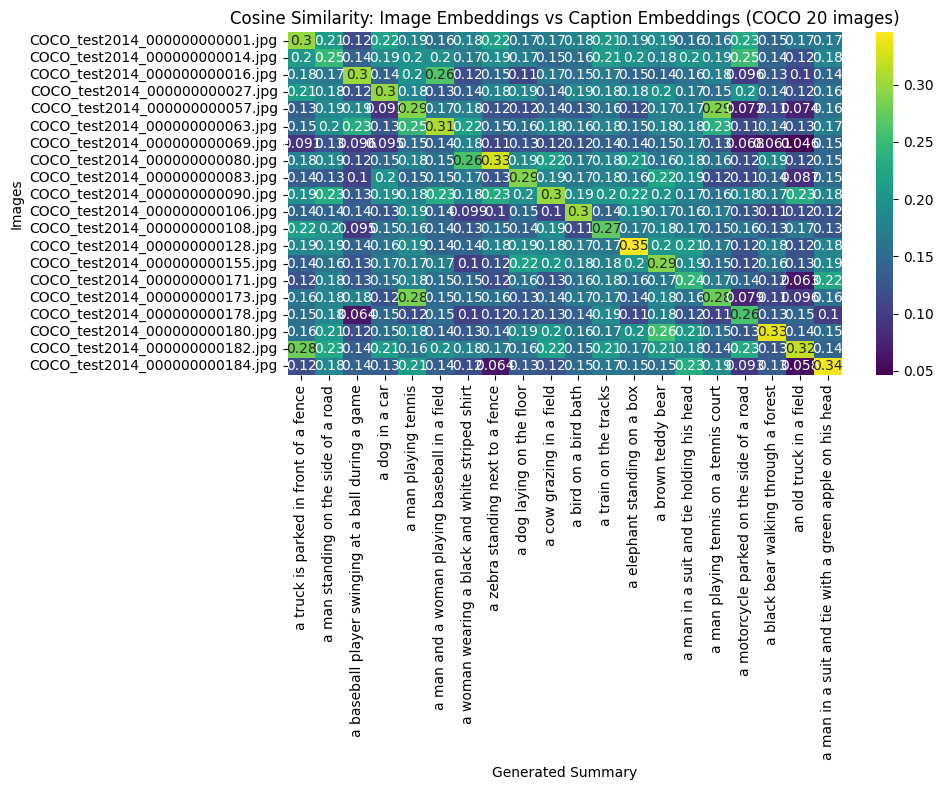

In [53]:
# Embed captions using SentenceTransformer or CLIP (if text)
caption_embeddings = clip_model.encode(captions)

# Reshape image embeddings to 2D (flatten batch dimension)
image_embeddings = image_embeddings.reshape(len(selected_image_paths), -1)

# Compute cosine similarity between image embeddings and caption embeddings
similarity_matrix = cosine_similarity(image_embeddings[:20], caption_embeddings[:20])

# Visualize the similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='viridis', xticklabels=captions[:20], yticklabels=[os.path.basename(p) for p in selected_image_paths[:20]])
plt.title("Cosine Similarity: Image Embeddings vs Caption Embeddings (COCO 20 images)")
plt.xlabel("Generated Summary")
plt.ylabel("Images")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

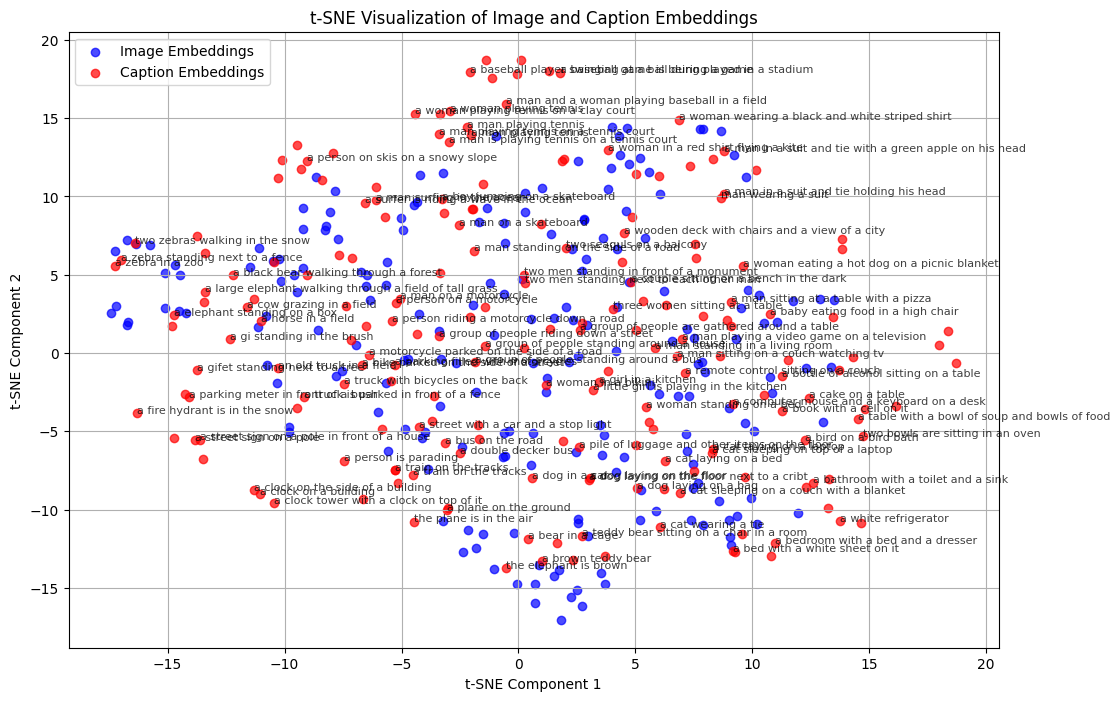

In [38]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Perform t-SNE on both image embeddings and caption embeddings
tsne = TSNE(n_components=2, random_state=42)

# Reduce the dimensionality of image embeddings
image_embeddings_2d = tsne.fit_transform(image_embeddings)

# Reduce dimensionality of caption embeddings
caption_embeddings_2d = tsne.fit_transform(caption_embeddings)

# Plot the embeddings
plt.figure(figsize=(12, 8))

# Plot image embeddings (scatter points in blue)
plt.scatter(image_embeddings_2d[:, 0], image_embeddings_2d[:, 1], color='blue', label="Image Embeddings", alpha=0.7)

# Plot caption embeddings (scatter points in red)
plt.scatter(caption_embeddings_2d[:, 0], caption_embeddings_2d[:, 1], color='red', label="Caption Embeddings", alpha=0.7)

# Add labels to each point in the caption embeddings
for i, caption in enumerate(captions[:100]):  # Plot only for selected images
    plt.annotate(caption, (caption_embeddings_2d[i, 0], caption_embeddings_2d[i, 1]), fontsize=8, alpha=0.75)

# Add title and labels
plt.title("t-SNE Visualization of Image and Caption Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.grid(True)
plt.show()


C:\Users\charu\anaconda3\envs\RAG\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\charu\anaconda3\envs\RAG\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


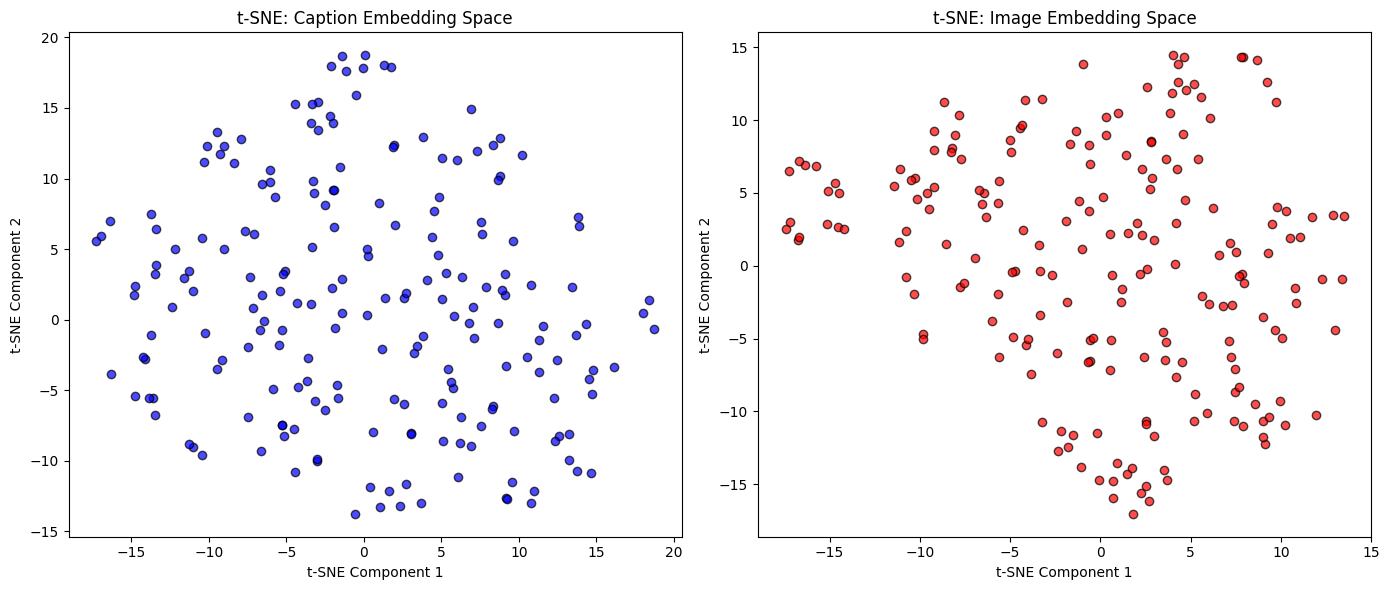

In [39]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Perform t-SNE for caption embeddings
tsne_caption = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
caption_embeddings_2d = tsne_caption.fit_transform(caption_embeddings)

# Perform t-SNE for image embeddings
tsne_image = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
image_embeddings_2d = tsne_image.fit_transform(image_embeddings)

# Plot the t-SNE results for caption embeddings
plt.figure(figsize=(14, 6))

# Subplot 1: Caption Embedding Space
plt.subplot(1, 2, 1)
plt.scatter(caption_embeddings_2d[:, 0], caption_embeddings_2d[:, 1], c='blue', edgecolor='k', alpha=0.7)
plt.title("t-SNE: Caption Embedding Space")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# Subplot 2: Image Embedding Space
plt.subplot(1, 2, 2)
plt.scatter(image_embeddings_2d[:, 0], image_embeddings_2d[:, 1], c='red', edgecolor='k', alpha=0.7)
plt.title("t-SNE: Image Embedding Space")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [43]:
original_captions = [
    "A truck is parked in front of a fence.",
    "A man is standing on the side of a road.",
    "A baseball player is swinging at a pitch during a game.",
    "A dog is inside a car.",
    "A man is playing tennis.",
    "A man and a woman are playing baseball in a field.",
    "A woman is wearing a black and white striped shirt.",
    "A zebra is standing next to a fence.",
    "A dog is lying on the floor.",
    "A cow is eating grass in a field.",
    "A bird is perched on a bird bath.",
    "A train is moving on the tracks.",
    "An elephant is standing on a box.",
    "A brown teddy bear.",
    "A man in a suit and tie is holding his head.",
    "A man is playing tennis on a court.",
    "A motorcycle is parked by the side of a road.",
    "A black bear is walking through a forest.",
    "An old truck is parked in a field.",
    "A man in a suit and tie has a green apple on his head.",
    "A remote control is on a couch.",
    "A plane is flying in the sky.",
    "A man is dressed in a suit.",
    "A boy is jumping on a skateboard.",
    "A man is playing tennis on a court.",
    "A gift is placed next to a tree.",
    "A woman is in a bikini.",
    "A surfer is riding a wave in the ocean.",
    "A bedroom features a bed and dresser.",
    "A clock tower has a clock on its top.",
    "A pile of luggage and items is on the floor.",
    "A group of people are riding down a street.",
    "A table is set with a bowl of soup and other dishes.",
    "A cat is sleeping on a couch under a blanket.",
    "A group of people are gathered around a table.",
    "A person is skiing down a snowy slope.",
    "A computer mouse and keyboard are on a desk.",
    "A man is playing tennis.",
    "A clock is on a building.",
    "Three women are sitting at a table.",
    "A group of people are gathered around a bus.",
    "A man is standing in a living room.",
    "A street sign is mounted on a pole in front of a house.",
    "A cake is placed on a table.",
    "A plane is on the runway.",
    "A person is in a parade.",
    "A little girl is playing in the kitchen.",
    "A man is sitting at a table eating pizza.",
    "A zebra is in a zoo.",
    "A man is on a skateboard.",
    "A truck has bicycles loaded on its back.",
    "A fire hydrant is covered in snow.",
    "A bear is in a cage.",
    "A parking meter stands in front of a bush.",
    "A man is on a motorcycle.",
    "A woman is standing on a bed.",
    "A man is sitting on a couch watching television.",
    "A cat is wearing a tie.",
    "A street sign is attached to a pole.",
    "A couple is sitting on a bench in the dark.",
    "A double-decker bus is parked.",
    "A wooden deck has chairs and a city view.",
    "A woman is playing tennis on a clay court.",
    "The elephant is brown.",
    "A baby is eating food in a high chair.",
    "A horse is in a field.",
    "A parking lot is filled with motorcycles.",
    "A bottle of alcohol sits on a table.",
    "Two zebras are walking in the snow.",
    "A cat is lying on a bed.",
    "A man is surfing in the ocean.",
    "Two seagulls are perched on a balcony.",
    "A person in a gi stands in the brush.",
    "Two men are standing next to each other.",
    "A bike is parked by the side of a street.",
    "A person is on a motorcycle.",
    "A person is riding a motorcycle down a road.",
    "A cat is lying on a laptop.",
    "A white refrigerator.",
    "A cat is sleeping on top of a laptop.",
    "Two men are standing in front of a monument.",
    "A group of people is gathered around a house.",
    "A girl is in the kitchen.",
    "A clock is attached to the side of a building.",
    "A woman is eating a hot dog on a picnic blanket.",
    "A street has a car and a stoplight.",
    "A baseball game is happening in a stadium.",
    "A woman is playing tennis.",
    "A teddy bear is sitting on a chair in a room.",
    "A dog is lying on a bag.",
    "A bed is covered with a white sheet.",
    "Two bowls are placed in an oven.",
    "A woman is in a red shirt flying a kite.",
    "A bathroom has a toilet and sink.",
    "A dog is lying next to a crib.",
    "A large elephant walks through a field of tall grass.",
    "A bus is on the road.",
    "A train is on the tracks.",
    "A book has a cell on it.",
    "A man is playing a video game on a TV.",
    "A man is standing next to a parking meter.",
    "A man is performing a trick on a skateboard.",
    "An elephant stands in a field.",
    "Two sheep are standing on gravel.",
    "A wooden fence.",
    "A banana has a brown spot.",
    "A blue bus.",
    "A park bench is surrounded by snow.",
    "A man in a green shirt and tie.",
    "A group of people.",
    "A person is skiing down a snowy slope.",
    "A man is sitting at a table with a laptop.",
    "A person is snowboarding down a hill.",
    "A motorcycle is on display.",
    "A group of people is riding motorcycles down a street.",
    "A line of trucks is parked.",
    "A group of men is walking down a red carpet.",
    "A woman is lying on a bed with a pair of shoes.",
    "A woman is lying on a bed.",
    "A man is in a green jacket.",
    "A group of people is walking on a beach.",
    "A boy is sitting at a desk.",
    "A plate of food.",
    "A group of buses is parked in a parking lot.",
    "A bed is covered with a white comforter.",
    "A police officer on a motorcycle is in front of a crowd.",
    "A man and a woman are sitting on a couch with a laptop.",
    "A statue of an elephant.",
    "A bathroom contains a toilet, sink, and shower stall.",
    "A cat is sleeping on a piece of luggage.",
    "A group of people is skiing down a snowy hill.",
    "A vase holds pink and yellow flowers on a table.",
    "A four-poster bed.",
    "A baseball player is about to catch the ball.",
    "A woman is sitting on a window sill.",
    "A woman is riding a horse.",
    "A laptop is on a table.",
    "A bathroom has a sink and mirror.",
    "A dog and a cat are playing in the leaves.",
    "A boy is sitting at a table.",
    "A blurry view of a baggage area.",
    "A cat is lying on a couch with a bag.",
    "A baseball game is being played.",
    "A group of people is sitting on the ground.",
    "A skate park.",
    "A hill.",
    "A teddy bear is standing on display.",
    "A man and woman are sitting at a table.",
    "A baseball player is in a baseball uniform.",
    "A group of cows is grazing in a field.",
    "A vase has a picture of a man on it.",
    "A man is in a blue shirt.",
    "Two women are standing in a living room.",
    "A woman is walking down a street with an umbrella.",
    "A young boy is on skis in the snow.",
    "A man is climbing a snowy mountain.",
    "A white cabinet has a bunch of glass items.",
    "A street sign with a solar panel on top.",
    "A train is on the tracks.",
    "A woman is holding an umbrella.",
    "A toddler is lying on a bed with a toy truck.",
    "A city street has a bus and cars.",
    "A man is performing a trick on a skateboard.",
    "A sheep is lying on hay.",
    "A cat is sitting in a bathtub.",
    "A table has bananas on it.",
    "A baseball player is swinging a bat.",
    "A bunch of kites.",
    "A row of bikes.",
    "A bunch of boats.",
    "A man in a red shirt is throwing a frisbee.",
    "A woman is on a surfboard.",
    "A woman is in the kitchen preparing food.",
    "A person is on a bike leaning on a pole.",
    "A woman is playing tennis.",
    "A pizza with pepperoni and cheese.",
    "A baseball player.",
    "A plate with a sandwich and green beans.",
    "A man in a wetsuit is surfing on a wave.",
    "A bunch of carrots.",
    "A dog is standing on the sidewalk next to a fire hydrant.",
    "A stop sign is on a pole.",
    "A group of people is sitting at a table.",
    "A woman is feeding a giraffe.",
    "A teddy bear is lying on another teddy bear.",
    "A train is on the tracks.",
    "A bed has a bag, toys, and other items on it.",
    "A red chair is in front of a building.",
    "A woman is holding a card.",
    "A plane is flying over a field of yellow flowers.",
    "A woman is skiing down a snowy hill.",
    "A man and woman are riding an elephant.",
    "A man is riding a skateboard down a ramp.",
    "A plane is on the runway.",
    "A group of people is riding horses through a forest.",
    "A black cat is sitting next to a stuffed teddy bear.",
    "A kitchen has a refrigerator and a sink.",
    "A yellow bus.",
    "A man is feeding pigeons.",
    "A man in a red jacket."
]


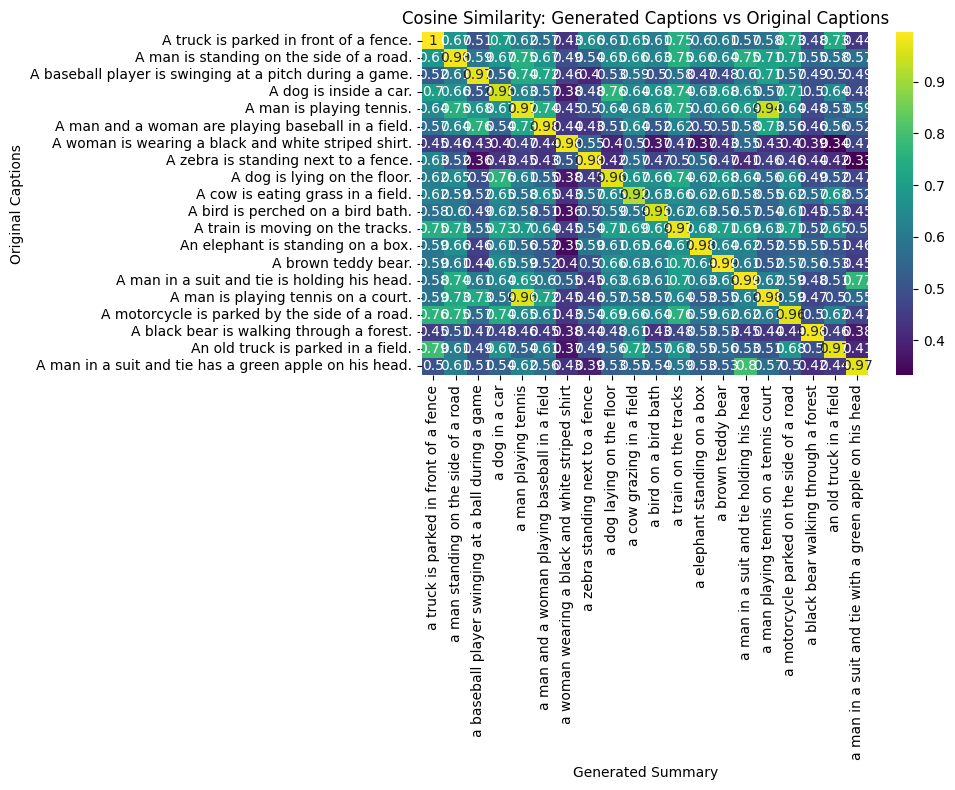

In [52]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


# Embed original captions and generated captions using the CLIP model
clip_model = SentenceTransformer("clip-ViT-B-32")
original_caption_embeddings = clip_model.encode(original_captions)
generated_caption_embeddings = clip_model.encode(captions)

# Compute cosine similarity between original captions and generated captions
similarity_matrix = cosine_similarity(original_caption_embeddings[:20], generated_caption_embeddings[:20])

# Visualize the similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='viridis', xticklabels=captions[:20], yticklabels=original_captions[:20])
plt.title("Cosine Similarity: Generated Captions vs Original Captions")
plt.xlabel("Generated Summary")
plt.ylabel("Original Captions")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Storing captions in chromaDB as placeholder for images

In [13]:
from dotenv import load_dotenv

# Load environment variables
load_dotenv('.env')

True

In [14]:
import json

# Path to the COCO captions JSON file
caption_folder =  './coco_dataset/captions_val2017.json'

# Load the JSON data
with open(caption_folder, 'r') as file:
    data = json.load(file)  # Parse the JSON file

# Retrieve the 'annotations' field
data = data['annotations']

# Verify by printing the first few entries
print("Total Annotations:", len(data))
print("First annotation entry:", data[0])


Total Annotations: 25014
First annotation entry: {'image_id': 179765, 'id': 38, 'caption': 'A black Honda motorcycle parked in front of a garage.'}


In [15]:
import pandas as pd
img_cap_pairs = []

for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_cap_pairs.append([img_name, sample['caption']])
    
BASE_PATH =  './coco_dataset'
captions = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])
captions['image'] = captions['image'].apply(
    lambda x: f'{BASE_PATH}/train2017/{x}'
)
captions = captions.sample(5000)
captions = captions.reset_index(drop=True)
captions.head()

,image,caption
0,./coco_dataset/train2017/000000504389.jpg,a couple of people that are playing in a field
1,./coco_dataset/train2017/000000521540.jpg,A banana is on a plate with cookies and peanut...
2,./coco_dataset/train2017/000000059635.jpg,Woman in wet suit considers waves near foreste...
3,./coco_dataset/train2017/000000411665.jpg,A kitten is looking into a mirror and touching...
4,./coco_dataset/train2017/000000575243.jpg,A BLACK AND WHITE PICTURE OF A PERSONA ND A UM...


In [17]:
# # Uncomment only if you want to add more stuff to chromaDB

# import pandas as pd
# from langchain.vectorstores import Chroma
# from langchain.embeddings.openai import OpenAIEmbeddings

# # Load the existing ChromaDB
# vectordb = Chroma(
#     persist_directory="./textual_dataset_chromaDB",  # Directory where the vector store is saved
#     embedding_function=OpenAIEmbeddings()  # Same embedding function as before
# )

# # Prepare new captions data as a list of documents
# new_documents = []
# new_metadatas = []

# for _, row in captions.iterrows():
#     caption_text = row['caption']  # The caption text
#     image_id = row['image']        # Path or ID of the image

#     # Each document contains the caption, and metadata links it to the image
#     new_documents.append(caption_text)
#     new_metadatas.append({"image_id": image_id})  # Metadata to track image IDs

# # Add the new captions into the existing ChromaDB vector store
# vectordb.add_texts(
#     texts=new_documents,        # List of captions
#     metadatas=new_metadatas     # List of metadata containing image paths/IDs
# )

# # Persist the updated ChromaDB
# vectordb.persist()

# print("Successfully added captions to ChromaDB!")


In [18]:
# Example query: Find images related to a specific caption or phrase
query_caption = "A person riding a horse on a beach"

# Search for similar captions in the ChromaDB
results = vectordb.similarity_search(query_caption, k=5)  # Return top 5 similar captions

# Display the results
print("Top 5 Results:")
for i, result in enumerate(results):
    print(f"Result {i+1}:")
    print(f"Caption: {result.page_content}")
    print(f"Image Path: {result.metadata['image_id']}")
    print("-" * 50)

Top 5 Results:
Result 1:
Caption: A person is riding a horse by the water
Image Path: ./coco_dataset/train2017/000000576052.jpg
--------------------------------------------------
Result 2:
Caption: Men on horse back riding on the beach
Image Path: ./coco_dataset/train2017/000000456015.jpg
--------------------------------------------------
Result 3:
Caption: A picture taken from a distance of people riding horses at the beach. 
Image Path: ./coco_dataset/train2017/000000434247.jpg
--------------------------------------------------
Result 4:
Caption: A couple of jockey's riding the horses through the beach.
Image Path: ./coco_dataset/train2017/000000360661.jpg
--------------------------------------------------
Result 5:
Caption: A picture of a person riding a horse.
Image Path: ./coco_dataset/train2017/000000227898.jpg
--------------------------------------------------


In [19]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
import json 

# Load the persisted vector store
vectordb = Chroma(
    persist_directory="./textual_dataset_chromaDB",  # Directory where your vector store is saved
    embedding_function=OpenAIEmbeddings()  # Same embedding function
)

# Access the Chroma collection
collection = vectordb._collection

# Fetch all embeddings and metadata
data = collection.get(include=['embeddings', 'documents', 'metadatas'])
all_embeddings = np.array(data.get("embeddings", []))  # Extract embeddings as numpy array
all_metadata = data.get("metadatas", [])

# Validate embeddings
if all_embeddings.size == 0:
    raise ValueError("No embeddings found in the vector store.")

# Perform a query and get relevant embeddings
query = "A person riding a horse on a beach"
retriever = vectordb.as_retriever(search_kwargs={"k": 5})  # Adjust k for the number of results
embedding_model = OpenAIEmbeddings()
query_embedding = embedding_model.embed_query(query)

C:\Users\charu\anaconda3\envs\RAG\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


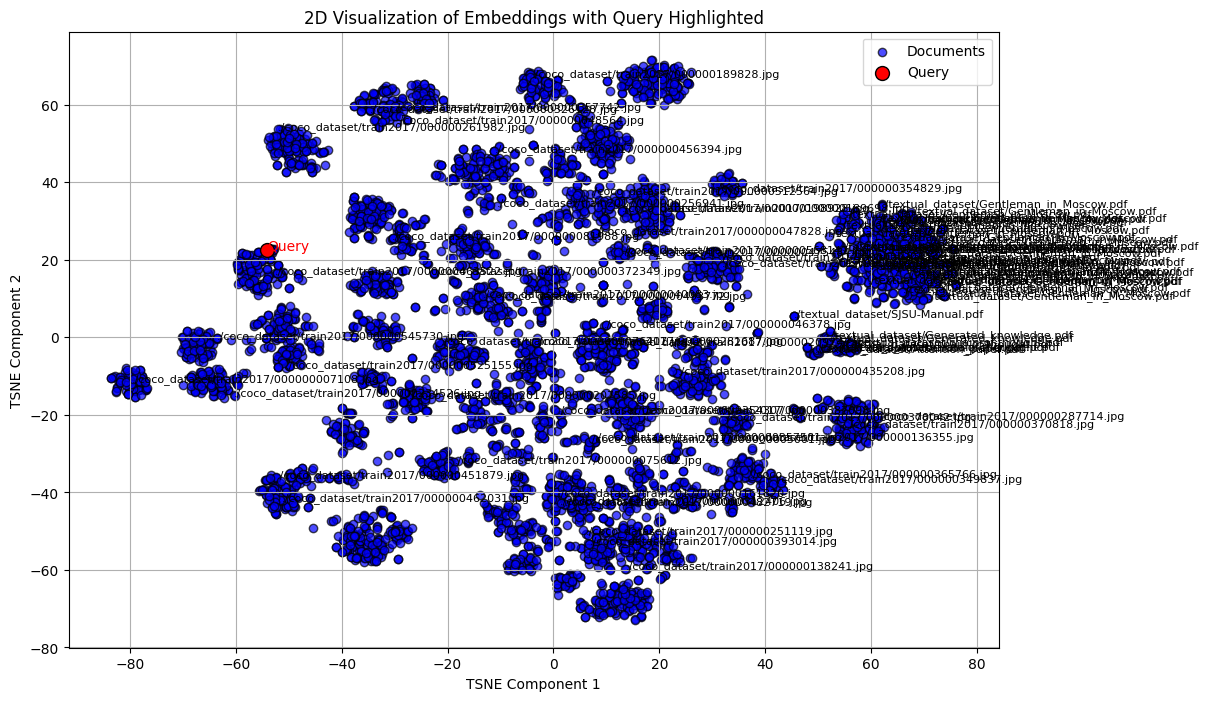

In [20]:
# Combine query embedding with document embeddings
all_embeddings = np.vstack([all_embeddings, query_embedding])
all_labels = all_metadata + [{"page": None, "source": "Query"}]

# Perform t-SNE again
tsne = TSNE(n_components=2, perplexity=min(30, len(all_embeddings) - 1), random_state=42, n_iter=1000)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Plot all embeddings
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:-1, 0], embeddings_2d[:-1, 1], c='blue', edgecolor='k', alpha=0.7, label='Documents')
plt.scatter(embeddings_2d[-1, 0], embeddings_2d[-1, 1], c='red', edgecolor='k', s=100, label='Query')

# Annotate metadata
for i, metadata in enumerate(all_metadata):
    if 'source' in metadata and i % 10 == 0:  # Avoid clutter by annotating every 10th point
        plt.annotate(metadata['source'], (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8)
    if 'image_id' in metadata and i % 100 == 0:  # Avoid clutter by annotating every 100th point
        plt.annotate(metadata['image_id'], (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8)

# Annotate query
plt.annotate("Query", (embeddings_2d[-1, 0], embeddings_2d[-1, 1]), fontsize=10, color='red')

plt.title("2D Visualization of Embeddings with Query Highlighted")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.legend()
plt.grid(True)
plt.show()


## Why we cannot directly combine image and text embeddings? 

In [7]:
## We lose information.
import numpy as np
from langchain_community.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings

# Initialize the embedding function
embedding_function = OpenAIEmbeddings()

# Load the first Chroma database
vectordb1 = Chroma(persist_directory="./textual_dataset_chromaDB", embedding_function=embedding_function)

# Load the second Chroma database
vectordb2 = Chroma(persist_directory="./coco_image_chromaDB", embedding_function=embedding_function)



# Access the Chroma collection
collection1 = vectordb1._collection

# Fetch all embeddings and metadata
data1 = collection1.get(include=['embeddings', 'documents', 'metadatas'])
embeddings1 = np.array(data1.get("embeddings", [])) # Extract embeddings as numpy array
all_metadata1 = data1.get("metadatas", [])

# Access the Chroma collection
collection2 = vectordb2._collection

# Fetch all embeddings and metadata
data2 = collection2.get(include=['embeddings', 'documents', 'metadatas'])
embeddings2 = np.array(data2.get("embeddings", [])) # Extract embeddings as numpy array
all_metadata2 = data2.get("metadatas", [])


# Combine the documents and embeddings from both databases
combined_documents = all_metadata1 + all_metadata2
combined_embeddings = embeddings1 + embeddings2

# Create a new Chroma database with the combined documents and embeddings
combined_vectordb = Chroma.from_documents(
    documents=combined_documents,
    embedding=embedding_function,
    persist_directory="./combined_chromaDB"
)

# Save the combined database
combined_vectordb.persist()


ValueError: operands could not be broadcast together with shapes (5534,1536) (12232,1536) 

## Evaluation (Text + Tables + Image Summary)

In [4]:
from dotenv import load_dotenv

# Load environment variables
load_dotenv('.env')

True

In [6]:
import os
import openai
from ragas import evaluate
from datasets import Dataset 
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
# from ragas.metrics.critique import harmfulness
from langchain_community.vectorstores import Chroma
# from langchain_experimental.text_splitter import SemanticChunker
from langchain_community.document_loaders import SeleniumURLLoader
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall, context_entity_recall, answer_correctness
from langchain.embeddings.openai import OpenAIEmbeddings

In [7]:
PROMPT_TEMPLATE = """
Go through the context and answer given question strictly based on context. 
Context: {context}
Question: {question}
Answer:
"""

# Load the persisted vector store
vectordb = Chroma(
    persist_directory="./textual_dataset_chromaDB",  # Directory where your vector store is saved
    embedding_function=OpenAIEmbeddings()  # Same embedding function
)

qa_chain = RetrievalQA.from_chain_type(
        llm = ChatOpenAI(temperature=0),
        retriever=vectordb.as_retriever(search_kwargs={'k': 3}),
        return_source_documents=True,
        chain_type_kwargs={"prompt": PromptTemplate.from_template(PROMPT_TEMPLATE)}
    )

C:\Users\charu\AppData\Local\Temp\ipykernel_17164\1141799357.py:11: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding_function=OpenAIEmbeddings()  # Same embedding function
C:\Users\charu\AppData\Local\Temp\ipykernel_17164\1141799357.py:9: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectordb = Chroma(


In [8]:
import pandas as pd

# Load the Excel file
file_path = "Ground_Truth_Data.xlsx"  # Replace with your file's path
data = pd.read_excel(file_path, engine='openpyxl')

# Extract the two columns as lists of strings
queries = data.iloc[:, 0].astype(str).tolist()  # Column 1
ground_truths = data.iloc[:, 1].astype(str).tolist()  # Column 2

# # Print the lists to verify
print("Queries:", queries[-5])
print("Ground Truth:", ground_truths[-5])


Queries: What is the small cat sitting on in the bathroom?,
Ground Truth: The cat is sitting in various places in the bathroom such as the sink, toilet, and the edge of the toilet seat.,


In [9]:
results = []
contexts = []
for query in queries:
    result = qa_chain({"query": query})
   
    results.append(result['result'])
    sources = result["source_documents"]
    contents = []
    for i in range(len(sources)):
        contents.append(sources[i].page_content)
    contexts.append(contents)

C:\Users\charu\AppData\Local\Temp\ipykernel_17164\545104327.py:4: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = qa_chain({"query": query})


In [10]:
print(len(queries))       # Check length of questions
print(len(results))       # Check length of answers
print(len(contexts))      # Check length of contexts
print(len(ground_truths)) # Check length of ground_truths


139
139
139
139


In [11]:
d = {
    "question": queries,
    "answer": results,
    "contexts": contexts,
    "ground_truth": ground_truths
}

dataset = Dataset.from_dict(d)
score = evaluate(dataset,metrics=[faithfulness, answer_relevancy, context_precision, context_recall, context_entity_recall, answer_correctness])
score_df = score.to_pandas()
score_df.to_csv("EvaluationScores.csv", encoding="utf-8", index=False)

Evaluating: 100%|████████████████████████████████████████████████████████████████████| 834/834 [10:49<00:00,  1.28it/s]


In [12]:
score_df[['faithfulness','answer_relevancy', 'context_precision', 'context_recall',
       'context_entity_recall', 'answer_correctness']].mean(axis=0)

faithfulness             0.676945
answer_relevancy         0.621564
context_precision        0.410072
context_recall           0.386816
context_entity_recall    0.157842
answer_correctness       0.421925
dtype: float64